In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score, mean_squared_error

from keras.layers import Dense, Dropout, Bidirectional, LSTM
from keras.models import Sequential

In [ ]:
#from tensorflow.python.client import device_lib


#device_lib.list_local_devices()

In [5]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving Jet_Sub.csv to Jet_Sub.csv
Saving Train_SU63ISt.csv to Train_SU63ISt.csv


In [7]:
df = pd.read_csv('Train_SU63ISt.csv',index_col='Datetime', parse_dates=['Datetime'])
df.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


In [8]:
df.drop(['ID'],axis=1,inplace=True)
df.head()

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6
2012-08-25 03:00:00,2
2012-08-25 04:00:00,2


In [9]:
len(df)

18288

In [10]:
df.tail()

,Count
Datetime,
2014-09-25 19:00:00,868
2014-09-25 20:00:00,732
2014-09-25 21:00:00,702
2014-09-25 22:00:00,580
2014-09-25 23:00:00,534


In [11]:
df.shape

(18288, 1)

In [12]:
 df.columns.get_loc("Count")

0

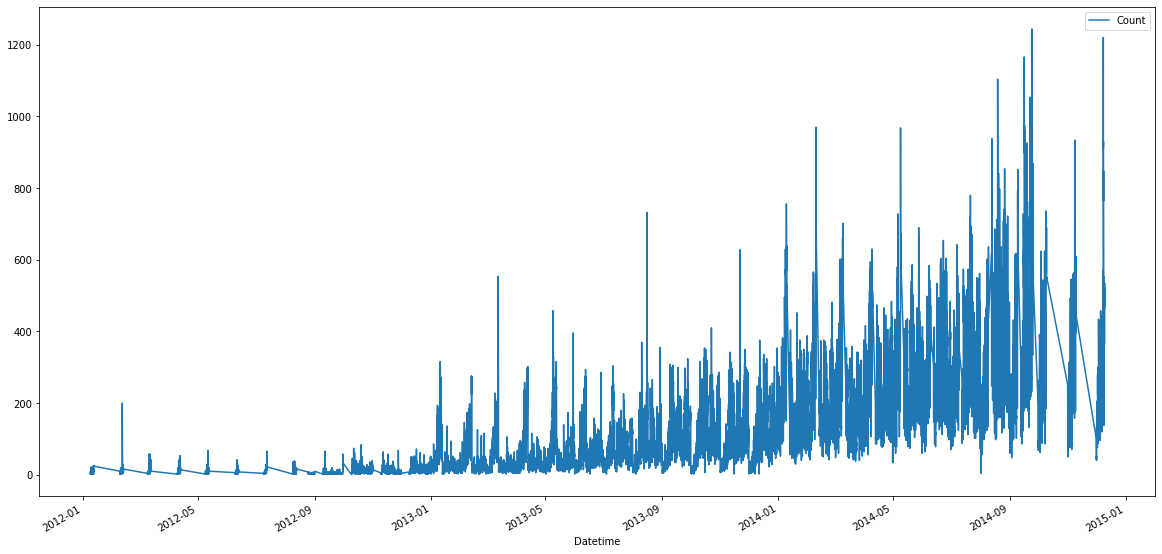

In [13]:
df.plot(figsize=(20,10),y='Count', legend=True)

In [14]:
df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['week_of_year'] = df.index.weekofyear
df['day_of_month'] = df.index.day
df['month_of_year'] = df.index.month
df['year'] = df.index.year

In [15]:
df.tail()

,Count,hour_of_day,day_of_week,week_of_year,day_of_month,month_of_year,year
Datetime,,,,,,,
2014-09-25 19:00:00,868,19,3,39,25,9,2014
2014-09-25 20:00:00,732,20,3,39,25,9,2014
2014-09-25 21:00:00,702,21,3,39,25,9,2014
2014-09-25 22:00:00,580,22,3,39,25,9,2014
2014-09-25 23:00:00,534,23,3,39,25,9,2014


In [16]:
 df.columns.get_loc("year")

6

In [17]:
f_cols = ['hour_of_day','day_of_week','week_of_year','day_of_month','month_of_year','year']
print(f_cols)

['hour_of_day', 'day_of_week', 'week_of_year', 'day_of_month', 'month_of_year', 'year']


Splitting the dataframe into training and testing data

In [19]:
split_date = '30-Apr-2014'
train_df = df.loc[df.index <= split_date].copy()
test_df = df.loc[df.index > split_date].copy()

In [20]:
print(train_df.shape, test_df.shape)

(14425, 7) (3863, 7)


In [21]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
mm_scaler = MinMaxScaler()

train_df['Count'] = mm_scaler.fit_transform(train_df['Count'].values.reshape(-1,1))
train_df.head()

,Count,hour_of_day,day_of_week,week_of_year,day_of_month,month_of_year,year
Datetime,,,,,,,
2012-08-25 00:00:00,0.006198,0,5,34,25,8,2012
2012-08-25 01:00:00,0.000000,1,5,34,25,8,2012
2012-08-25 02:00:00,0.004132,2,5,34,25,8,2012
2012-08-25 03:00:00,0.000000,3,5,34,25,8,2012
2012-08-25 04:00:00,0.000000,4,5,34,25,8,2012


In [24]:
test_df['Count'] = mm_scaler.transform(test_df['Count'].values.reshape(-1,1))
test_df.head()

,Count,hour_of_day,day_of_week,week_of_year,day_of_month,month_of_year,year
Datetime,,,,,,,
2014-05-01 00:00:00,0.109504,0,3,18,1,5,2014
2014-05-01 01:00:00,0.086777,1,3,18,1,5,2014
2014-05-01 02:00:00,0.064050,2,3,18,1,5,2014
2014-05-01 03:00:00,0.033058,3,3,18,1,5,2014
2014-05-01 04:00:00,0.061983,4,3,18,1,5,2014


In [25]:
def create_dataset(X,y, time_steps=1):
  Xs, ys = [], [] 
  for i in range(len(X)-time_steps):
    v = X.iloc[i:(i+time_steps)].to_numpy()
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs), np.array(ys) 

In [26]:
TIME_STEPS = 24

train_X, train_y = create_dataset(train_df, train_df.Count, time_steps=TIME_STEPS)
test_X, test_y = create_dataset(test_df, test_df.Count, time_steps=TIME_STEPS)

In [27]:
print(train_X.shape, train_y.shape)

(14401, 24, 7) (14401,)


In [28]:
print(test_X.shape, test_y.shape)

(3839, 24, 7) (3839,)


In [29]:
def load_data_train(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i])
        y_train.append(stock.iloc[i, 0])
    
    #1 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #2 reshape data to input into RNN models
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 7))
    
    return [X_train, y_train]

In [ ]:
def load_data_test(stock, seq_len):
    X_test = []
    y_test = []
    for i in range(seq_len, len(stock)):
        X_test.append(stock.iloc[i-seq_len : i])
        y_test.append(stock.iloc[i, 0])
    
    #1 convert to numpy array
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #2 reshape data to input into RNN models
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 7))
    
    return [X_test, y_test]

In [ ]:
#create train, test data
seq_len = 24 #choose sequence length

X_train, y_train  = load_data_train(train_df, seq_len)
X_test, y_test = load_data_test(test_df,seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)


In [40]:
lstm_model = Sequential()

lstm_model.add(LSTM(64,activation="tanh",return_sequences=True, input_shape=(train_X.shape[1],train_X.shape[2])))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(64,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(64,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 64)            18432     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(units=128,input_shape=(train_X.shape[1], train_X.shape[2]))))

#lstm_model.add(LSTM(40,activation="tanh",return_ sequences=False))
model.add(Dropout(rate=0.20))

model.add(Dense(units=1))

model.summary()

In [41]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(train_X, train_y, epochs=30, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/30
405/405 [==============================] - 15s 36ms/step - loss: 0.0037 - val_loss: 0.0244
Epoch 2/30
405/405 [==============================] - 14s 33ms/step - loss: 0.0032 - val_loss: 0.0240
Epoch 3/30
405/405 [==============================] - 13s 33ms/step - loss: 0.0032 - val_loss: 0.0230
Epoch 4/30
405/405 [==============================] - 14s 33ms/step - loss: 0.0032 - val_loss: 0.0234
Epoch 5/30
405/405 [==============================] - 13s 33ms/step - loss: 0.0031 - val_loss: 0.0231
Epoch 6/30
405/405 [==============================] - 13s 33ms/step - loss: 0.0031 - val_loss: 0.0236
Epoch 7/30
405/405 [==============================] - 14s 34ms/step - loss: 0.0032 - val_loss: 0.0237
Epoch 8/30
405/405 [==============================] - 14s 34ms/step - loss: 0.0032 - val_loss: 0.0240
Epoch 9/30
405/405 [==============================] - 14s 34ms/step - loss: 0.0033 - val_loss: 0.0234
Epoch 10/30
405/405 [==============================] - 13s 33ms/step - loss: 0.003

In [42]:
lstm_predictions = lstm_model.predict(test_X)

lstm_rmse = np.sqrt(mean_squared_error(test_y, lstm_predictions))
lstm_score = r2_score(test_y, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)
print(" RMSE of LSTM model : ", lstm_rmse)

R^2 Score of LSTM model =  -0.6190969708839449
 RMSE of LSTM model :  0.22672518281519186


In [43]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(20,10))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

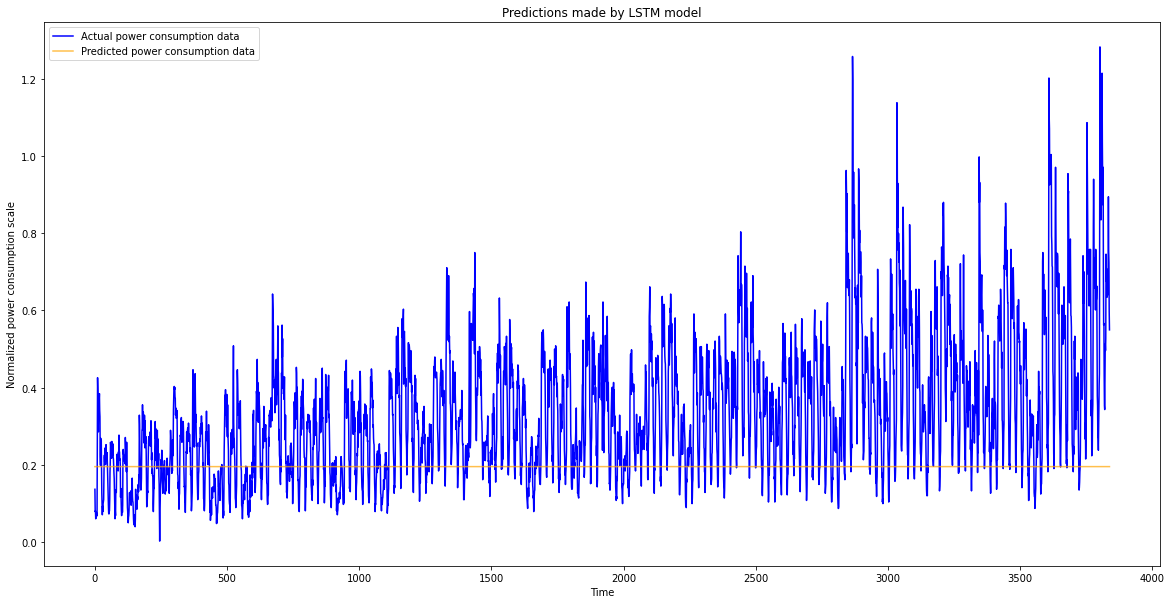

In [45]:
plot_predictions(test_y, lstm_predictions, "Predictions made by LSTM model")